In [51]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os 
from scipy.stats import binom_test
from sequencing_tools.stats_tools import p_adjust
from scipy.stats import beta
from scipy.special import betaln
from functools import partial
from repeats_utils import *
from plotting_utils import spring_layout
from math import log
#import adjustText
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
count_table = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv'
df = pd.read_table(count_table)
df.head()

,gene_id,gene_name,gene_type,grouped_type,IGG-cf_R1_001:all:antisense,IGG-cf_R1_001:all:sense,IGG-cf_R1_001:dedup:antisense,IGG-cf_R1_001:dedup:sense,QCF1_R1_001:all:antisense,QCF1_R1_001:all:sense,...,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense,genome-sim_R1_001:all:antisense,genome-sim_R1_001:all:sense,genome-sim_R1_001:dedup:antisense,genome-sim_R1_001:dedup:sense
0,.,.,No features,No features,0,0,0,0,1164939,69311,...,0,0,0,0,0,0,26647609,26664118,26647609,26664118
1,.,.,tRNA,tRNA,0,0,0,0,10237961,0,...,0,0,0,0,0,0,568,0,568,0
2,.,No features:.,Repeats,Repeats,3745,4542,2989,3742,35812,17223,...,94446,92684,159513,155574,101781,100419,16867723,16876133,16867723,16876133
3,18S_rRNA,18S_rRNA,rDNA,rRNA,0,0,0,0,734,175520,...,0,0,0,0,0,0,225,252,225,252
4,28S_rRNA,28S_rRNA,rDNA,rRNA,0,0,0,0,1089,384807,...,0,0,0,0,0,0,506,533,506,533


(3.0400600236661712, 3.0342780746836864, 0, 1)


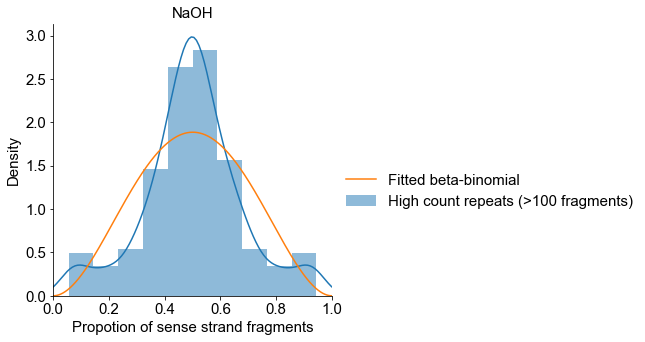

In [36]:
fig = plt.figure(figsize=(5,5))
#ax = fig.add_subplot(121)
sample_regex = 'Q[cC][fF][0-9]+'
#sample_regex = '[aA][lL][lL]'
p_df = get_repeat_df(df, sample_regex = sample_regex)
#alpha0, beta0 = model_df(p_df, ax, title = 'DNase-I')
#ax.legend().set_visible(False)

ax = fig.add_subplot(111)
sample_regex = 'Q[cC][fF]_[Nn][aA]'
naoh_p_df = get_repeat_df(df, sample_regex = sample_regex)
naoh_alpha0, naoh_beta0 = model_df(naoh_p_df, ax, title= 'NaOH')
ax.legend(bbox_to_anchor = (1,0.5), fontsize=15, frameon=False)

Text(22.125, 0.5, 'Posterior sense strand proportion')

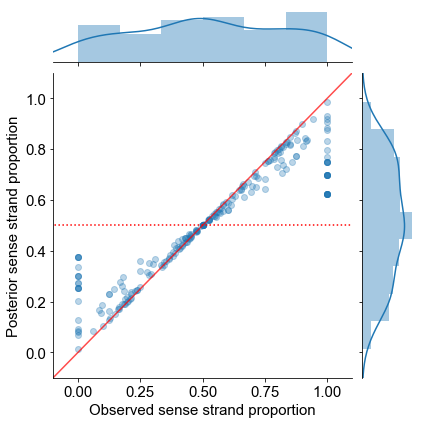

In [37]:
dnase_posterior_df = update_empirical_bayesr(p_df, naoh_alpha0, naoh_beta0)
naoh_posterior_df = update_empirical_bayesr(naoh_p_df, naoh_alpha0, naoh_beta0)


p = sns.JointGrid(data = dnase_posterior_df,  x= 'average',y='eb_estimate')
p.plot_joint(plt.scatter, alpha=0.3)
p.plot_marginals(sns.distplot)
ax = p.ax_joint
ax.hlines(xmin=-10,xmax=10, 
          y=naoh_alpha0/(naoh_alpha0+naoh_beta0), color='r', linestyle=':')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
ax.plot(lims, lims, 'r-', alpha=.7)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Observed sense strand proportion')
ax.set_ylabel('Posterior sense strand proportion')
#sns.despine()

In [38]:
dnase_posterior_df.head()

,antisense,gene_id,gene_name,sense,average,eb_estimate,alpha1,beta1
768,5958,Satellite,Satellite:(CATTC)n,4151,0.410624,0.410678,4154.04006,5961.034278
769,2343,Satellite,Satellite:(GAATG)n,5729,0.709737,0.709580,5732.04006,2346.034278
770,517,Satellite,Satellite:BSR/Beta,399,0.435590,0.436017,402.04006,520.034278
771,139,Satellite,Satellite:CER,88,0.387665,0.390605,91.04006,142.034278
772,17,Satellite,Satellite:D20S16,11,0.392857,0.412042,14.04006,20.034278


In [71]:
posterior_df = pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
         naoh_posterior_df.assign(treatment='NaOH')]) \
    .pipe(pd.melt, id_vars = ['treatment','gene_name','gene_id']) \
    .assign(variable = lambda d: d.treatment + ': ' + d.variable) \
    .pipe(pd.pivot_table, index=['gene_name', 'gene_id'],
         columns = 'variable', values = 'value') \
    .pipe(lambda d: fill_prior(d, (naoh_alpha0, naoh_beta0)))\
    .reset_index() \
    .fillna(0)\
    .pipe(lambda d: calulate_probability(d))  \
    .assign(delta_sense = lambda d: d['DNase: eb_estimate'] - d['NaOH: eb_estimate'])
#posterior_df.sort_values('bayes_factor', ascending=False).head(20)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


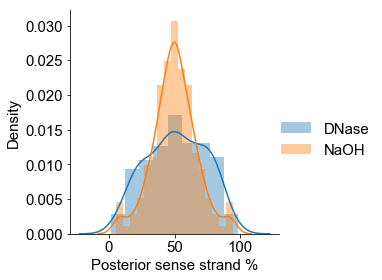

In [72]:
p = sns.FacetGrid(data =pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
                            naoh_posterior_df.assign(treatment='NaOH')])\
                      .assign(eb_estimate = lambda d: d.eb_estimate * 100), 
              hue = 'treatment',
              size = 4)
p.map(sns.distplot, 'eb_estimate')
p.set_axis_labels('Posterior sense strand %',
                'Density')
p.add_legend(title='', fontsize=15)

In [77]:
#https://repository.upenn.edu/cgi/viewcontent.cgi?article=3272&context=edissertations
telo = 'TAACCC|CCCGAA|CCCCAA|CCCTAG|TTAGGC|TTAGGG'
telo += '|' + reverse_complement(telo)
x_val = 'delta_sense'
y_val = 'log_bf'
plot_bf_df = posterior_df\
    .query('bayes_factor  > 0') \
    .assign(label = lambda d: np.where(d[x_val] < 0, 'Antisense','Sense')) \
    .assign(color = lambda d: np.where(d.label == "Antisense", 'gray', 'black'))\
    .assign(color = lambda d: np.where((d.label != "Antisense") & (d.h0_p > 5), 'red', d.color))\
    .sort_values('log_bf', ascending=False)
plot_bf_df.head()

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,...,NaOH: sense,h0_p,h_p,log_bf,bayes_factor,pval,qval,delta_sense,label,color
3,Satellite:ALR/Alpha,centr,6011.04006,5431.0,0.525221,5434.034278,0.525208,6008.0,1.096844e+06,921764.0,...,1096841.0,0.0,0.0,2.767361e+06,2.634253e+64,0.999951,131.825933,-0.018158,Antisense,gray
14,Satellite:HSATII,Satellite,2540.04006,2186.0,0.537159,2189.034278,0.537111,2537.0,4.512930e+05,283025.0,...,451290.0,0.0,0.0,9.726166e+05,7.575595e+59,1.000000,148.825893,-0.077460,Antisense,gray
0,Satellite:(CATTC)n,Satellite,4154.04006,5958.0,0.410624,5961.034278,0.410678,4151.0,1.928200e+05,116072.0,...,192817.0,0.0,0.0,3.961680e+05,9.523453e+55,1.000000,161.825893,-0.213547,Antisense,gray
1,Satellite:(GAATG)n,Satellite,5732.04006,2343.0,0.709737,2346.034278,0.709580,5729.0,4.401404e+04,67827.0,...,44011.0,0.0,0.0,1.417453e+05,3.274070e+51,0.000000,0.000000,0.316050,Sense,black
4,Satellite:BSR/Beta,Satellite,402.04006,517.0,0.435590,520.034278,0.436017,399.0,4.214304e+04,52671.0,...,42140.0,0.0,0.0,1.290136e+05,1.277486e+51,0.698258,61.141076,-0.008450,Antisense,gray


In [76]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
for lab, lab_df in  plot_bf_df.groupby('label'):
    if lab == "Sense":
        alpha = 0.8
        color = 'black' 
        
        data = []
        text = []
        colors = []
        for i, row in lab_df.iterrows():
            x = row[x_val]
            y = row[y_val]
            data.append((x,y))
            if row[x_val] > 0 \
                    and (row[y_val] > 10 or (row[y_val] > 0 and re.search(telo, row['gene_name']))): 
                text.append(row['gene_name'])
                
                ax.annotate(row['gene_name'].split(':')[1],
                    xy=(x, y), xycoords='data',
                    xytext=(x, y + 1), textcoords='data',
                    color = row['color'],
                    arrowprops=dict(arrowstyle="->",
                            color = row['color'],
                            connectionstyle="arc3"),
            )
            else:
                text.append('')
            colors.append(row['color'])
        #spring_layout(ax, data, text, colors = colors)
    else:
        alpha = 0.2
        color = 'gray'
    
    lab_df.plot.scatter(x_val, y_val, ax = ax, color = lab_df.color.tolist())#, alpha=alpha )
plt.axvline(x = 0, linestyle=':', alpha=0.01, color='gray')
sns.despine()
ax.set_ylim(0,100)
ax.set_ylabel('log(Bayes factor)')
ax.set_xlabel('$\Delta$Sense |DNase - NaOH|')

Text(0.5, 0, '$\\Delta$Sense |DNase - NaOH|')

ValueError: Image size of 379x385331 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 360x360 with 1 Axes>

In [ ]:
plot_bf_df[plot_bf_df.gene_name.str.contains(telo+'|telo')]

In [ ]:
posterior_df['total'] =  posterior_df['DNase: antisense'] + posterior_df['DNase: sense']
posterior_df['x'] = posterior_df['DNase: eb_estimate'] * 100
posterior_df['y'] = posterior_df['NaOH: eb_estimate'] * 100

ax = plt.subplot(111)
for i, row in posterior_df.iterrows():
    if  ( row['y']/row['x'] > 2 and row['y'] > 50) or \
            (re.search(telo, row['gene_name']) and row['DNase: eb_estimate'] > row['NaOH: eb_estimate']):
        color = 'purple' if re.search(telo, row['gene_name']) else 'red'
        ax.text(row['x'],row['y'],
               row['gene_name'].replace('Simple_repeats:',''), 
                color=color,ha='left')
    else:
        color = 'grey'
        
    ax.scatter(row['x'], row['y'] , color = color, alpha=0.5)
ax.plot([0,100],[0,100], color = 'orange')
ax.set_ylabel('Posterior DNase sense strand mapping (%)')
ax.set_xlabel('Posterior NaOH sense strand mapping (%)')
ax.set_xlim(0,posterior_df['x'].max() * 1.1)
ax.set_ylim(0,posterior_df['y'].max() * 1.1)
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
sns.despine()

In [ ]:
from scipy.stats import binom
from math import log, exp
from scipy.special import betaln

s = 
f = 
N = s + f

# sf is the survival function, i.e. complementary cdf
# ccdf multiplied by 2 because we're doing a two-sided test
print("p-value: ", 2*binom.sf(s, N, 0.5))

# Compute the log of the Bayes factor to avoid underflow.
logbf = N*log(0.5) - betaln(s+0.5, f+0.5) + betaln(0.5, 0.5)
print("Bayes factor: ", exp(logbf))

In [ ]:
posterior_df.head()